<a href="https://colab.research.google.com/github/shahbashajahan/ict-ml2/blob/main/movie_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install nltk

In [14]:
import nltk

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from bs4 import BeautifulSoup
import string
from collections import Counter
from wordcloud import WordCloud
from scipy.stats import randint

import warnings
warnings.filterwarnings("ignore")

In [17]:
df = pd.read_csv("/content/IMDB Dataset.csv.zip")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [19]:
# Remove HTML tags
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Apply function to dataset
df["review"] = df["review"].apply(remove_html_tags)

In [20]:
# Remove pecial characters and numbers
df["review"] = df["review"].str.replace("[^a-zA-Z]", " ", regex=True)

# Remove extra spaces
df["review"] = df["review"].str.replace("\s+", " ", regex=True).str.strip()

In [21]:
# Remove punctuation
punctuation_pattern = f"[{string.punctuation}]"
df["review"] = df["review"].str.replace(punctuation_pattern, "", regex=True)

In [22]:
# Lowercase
df["review"] = df["review"].str.lower()

In [23]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [24]:
# Tokenization
df["review"] = df["review"].apply(word_tokenize)

In [25]:
# Remove stop words
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def remove_stop_words(token_list):
    return [word for word in token_list if word not in stop_words]

df["review"] = df["review"].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
# Stemming
def stem_tokens(token_list):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in token_list]

df["review"] = df["review"].apply(stem_tokens)

In [27]:
# Extract high-frequency words
all_tokens = [token for sublist in df["review"] for token in sublist]
word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)
most_common_words

[('movi', 103241),
 ('film', 95853),
 ('one', 55435),
 ('like', 45197),
 ('time', 31953),
 ('good', 30179),
 ('make', 30020),
 ('charact', 28347),
 ('see', 28235),
 ('get', 27963),
 ('watch', 27873),
 ('even', 25347),
 ('stori', 25272),
 ('would', 24599),
 ('realli', 23090),
 ('well', 21784),
 ('scene', 21434),
 ('look', 19945),
 ('show', 19913),
 ('much', 19316)]

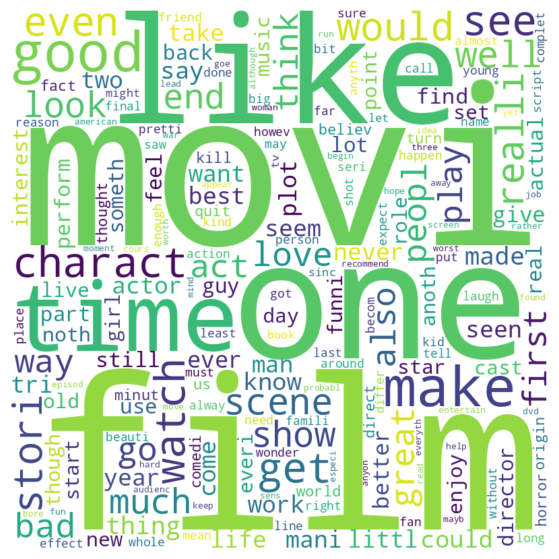

In [28]:
# Visualize it using wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide the axes
plt.show()

In [29]:
# Join the tokens back into strings for the vectorizer
df["joined_review"] = df["review"].apply(" ".join)
text_data = df["joined_review"]
tfidf_vectorizer = TfidfVectorizer(max_features=2000)

# Fit the vectorizer to the text data and transform it into TF-IDF features
x_tfidf = tfidf_vectorizer.fit_transform(text_data)
x_tfidf

<50000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 3571126 stored elements in Compressed Sparse Row format>

In [30]:
# Converting categorical labels to numerical form

df["sentiment_numeric"] = df["sentiment"].map({"positive": 1, "negative": 0})

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(x_tfidf, df["sentiment_numeric"], test_size=0.2, random_state=1)

In [31]:
# Scale data
scaler = MaxAbsScaler()

# Scale the training and test sets
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [32]:
# Train MLP model
mlp_model = MLPClassifier()
mlp_model.fit(x_train_scaled, y_train)


MLPClassifier()

In [33]:
# Evaluate the Model
y_pred = mlp_model.predict(x_test_scaled)

# Calculate accuracy
mlp_accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {mlp_accuracy}")

# Print classification report for a detailed performance analysis
print(classification_report(y_test, y_pred))

Model accuracy: 0.8756
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5044
           1       0.87      0.88      0.88      4956

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



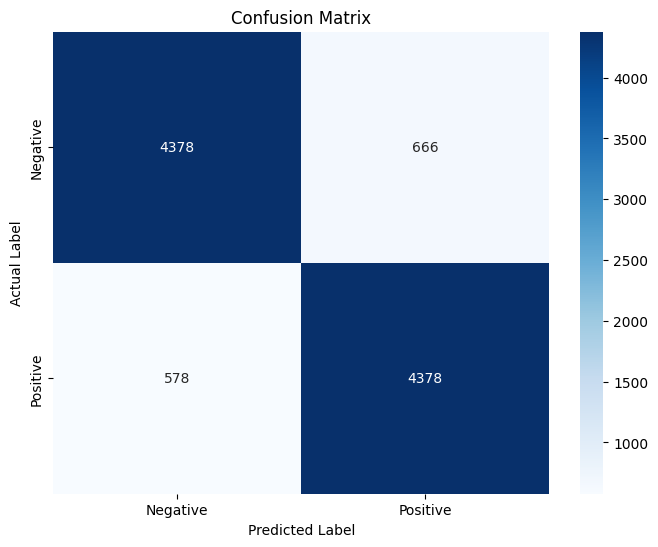

In [34]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [35]:
# Define a function to get all scores
def get_scores(y_true, y_pred_prob, threshold=0.5):

    y_pred = (y_pred_prob[:, 1] >= threshold).astype(int)

    scores = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'Roc_Auc': roc_auc_score(y_true, y_pred_prob[:, 1])
    }

    return scores

y_pred_mlp_prob = mlp_model.predict_proba(x_test_scaled)

# Now call the function with the true labels and the predicted probabilities
scores_mlp = get_scores(y_test, y_pred_mlp_prob)
scores_mlp

{'Accuracy': 0.8756,
 'Precision': 0.8679619349722443,
 'Recall': 0.8833736884584342,
 'F1': 0.8756,
 'Roc_Auc': 0.9478590822073262}

In [36]:
# Sample text to predict sentiment
sample_text = [
    "This movie was a great watch with brilliant performances and a gripping plot!",  # Positive
    "An absolute waste of time, the worst movie I've seen in a long while.",  # Negative
    "I found the movie to be mediocre, not terrible but not great either.",  # Neutral
    "The cinematography was stunning, but the storyline was lacking and unoriginal.",  # Neutral/Negative
    "The film was a masterpiece with a perfect blend of drama and action, a must-watch!",  # Positive
    "It was an okay movie; I neither liked it nor disliked it particularly.",  # Neutral
    "The plot twist at the end was predictable and uninspired.",  # Negative
    "A stellar cast, but the film fell flat due to poor writing.",  # Negative
    "I loved the special effects, but the characters were not very compelling.",  # Neutral/Negative
    "The movie was well-received by critics but I didn't find it very interesting.",  # Neutral
    "This film is overrated, I had high expectations but was sadly disappointed.",  # Negative
    "What an entertaining experience, I was on the edge of my seat the whole time!"  # Positive
]

for text in sample_text:
    # Convert the text to TF-IDF features
    sample_tfidf = tfidf_vectorizer.transform([text])

    # Scale the features because we scaled during training
    sample_scaled = scaler.transform(sample_tfidf)

    # Make a prediction
    prediction_prob = mlp_model.predict_proba(sample_scaled)

    # Get the predicted probability of the positive class
    positive_prob = prediction_prob[0, 1]

    # Apply threshold to convert probabilities to class labels
    prediction = 1 if positive_prob > 0.5 else 0

    # Output the prediction
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"{text} ->  {sentiment}")
    # print(f"Predicted sentiment: {sentiment}")

This movie was a great watch with brilliant performances and a gripping plot! ->  Positive
An absolute waste of time, the worst movie I've seen in a long while. ->  Negative
I found the movie to be mediocre, not terrible but not great either. ->  Positive
The cinematography was stunning, but the storyline was lacking and unoriginal. ->  Negative
The film was a masterpiece with a perfect blend of drama and action, a must-watch! ->  Positive
It was an okay movie; I neither liked it nor disliked it particularly. ->  Negative
The plot twist at the end was predictable and uninspired. ->  Positive
A stellar cast, but the film fell flat due to poor writing. ->  Negative
I loved the special effects, but the characters were not very compelling. ->  Positive
The movie was well-received by critics but I didn't find it very interesting. ->  Positive
This film is overrated, I had high expectations but was sadly disappointed. ->  Negative
What an entertaining experience, I was on the edge of my seat